# Problem statement:

- The goal is to develop a Convolutional Neural Network (CNN) model capable of accurately identifying melanoma, a potentially lethal form of cancer. Timely detection is crucial as melanoma accounts for a substantial portion, specifically 75%, of skin cancer-related fatalities.

- The objective is to create a multiclass classification model that leverages the power of custom-designed CNNs, implemented using TensorFlow.

- This CNN-based model aims to analyze medical images and provide alerts to dermatologists regarding the presence of melanoma. By doing so, it has the potential to significantly reduce the manual effort and time required for diagnosis.

- The classification task involves categorizing skin lesions into multiple classes, including melanoma. The model will be trained to make accurate predictions and assist medical professionals in early detection.

- The project's significance lies in its potential to enhance the efficiency and accuracy of melanoma diagnosis, ultimately contributing to improved patient outcomes and potentially saving lives through early intervention.

### Importing Librariies & Skin Cancer Data
####Taking necessary actions to read the data

In [31]:
# Import the 'pathlib' library for working with file paths and directories
import pathlib

# Import TensorFlow for building and training neural networks
import tensorflow as tf

# Import Matplotlib and seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import NumPy for numerical operations
import numpy as np

# Import Pandas for data manipulation (reading and processing data)
import pandas as pd

# Import 'os' for operating system-related functions
import os

# Import 'cv2' for computer vision tasks (OpenCV library)
import cv2

# Import 'PIL' for image processing (Python Imaging Library)
import PIL

# Import specific modules from TensorFlow and Keras for neural network construction
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Activation,
    Flatten,Conv2D,
    MaxPooling2D
)

# Data Reading/Data Understanding

Defining the path for train and test images

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [5]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [7]:
# Define some parameters for the loader
batch_size = 32
img_height, img_width = 180, 180

Use 80% of the images for training, and 20% for validation.

In [8]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [11]:
# Listing out all the classes of skin cancer and store them in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

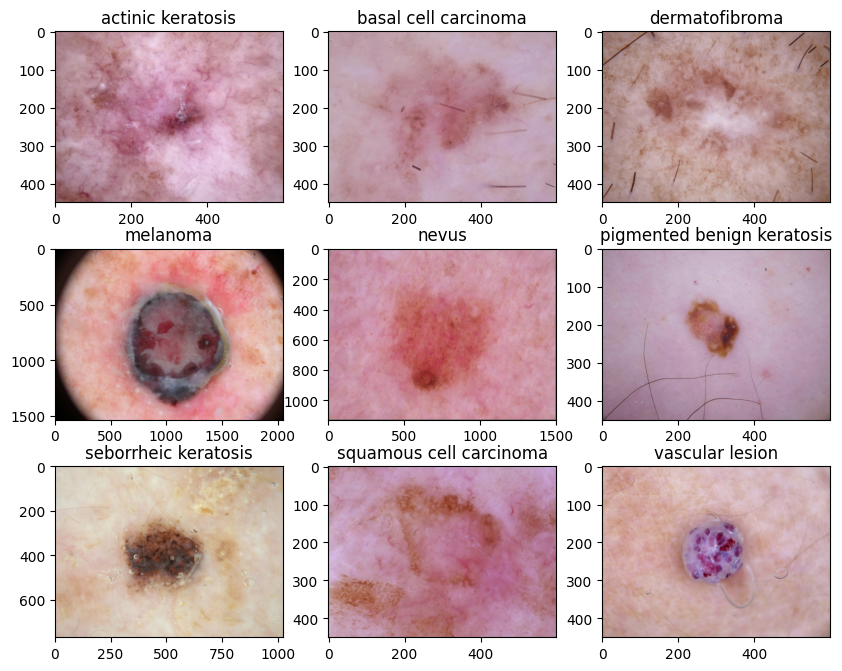

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,8))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.\
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

# Model Building & training :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

### Model Architecture

- The model begins with rescaling the input image pixel values to the range [0, 1].
- It then applies two convolutional layers, each followed by max-pooling, to extract features from the image.
- The first convolutional layer has 64 filters, and the second has 128 filters, both using ReLU activation functions.

- The feature maps are flattened into a 1D vector, which is then passed through a fully connected layer with 256 units and ReLU activation.

- Finally, the output layer consists of 9 units, using softmax activation for multi-class classification.


In [14]:
# Create a Sequential model
model = models.Sequential()

# Rescale the input image pixel values to the range [0, 1]
model.add(layers.Rescaling(scale=1./255, input_shape=(180, 180, 3)))

# Add a convolutional layer with 64 filters, each of size (3,3),
# using 'same' padding, and ReLU activation function
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

# Add a max-pooling layer to downsample the feature maps
model.add(layers.MaxPooling2D())

# Add another convolutional layer with 128 filters, each of size (3,3),
# using 'same' padding, and ReLU activation function
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))

# Add another max-pooling layer to downsample the feature maps
model.add(layers.MaxPooling2D())

# Flatten the 2D feature maps into a 1D vector
model.add(layers.Flatten())

# Add a fully connected (dense) layer with 256 units and ReLU activation
model.add(layers.Dense(256, activation='relu'))

# Add the output layer with 9 units and softmax activation for classification
model.add(layers.Dense(9, activation='softmax'))


In [15]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)            0

In [16]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 312s 1s/step - loss: 2.9635 - accuracy: 0.1908 - val_loss: 1.9699 - val_accuracy: 0.2774
Epoch 2/20
56/56 [==============================] - 4s 67ms/step - loss: 1.8277 - accuracy: 0.3410 - val_loss: 1.7466 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 4s 69ms/step - loss: 1.5864 - accuracy: 0.4621 - val_loss: 1.7187 - val_accuracy: 0.4027
Epoch 4/20
56/56 [==============================] - 4s 67ms/step - loss: 1.4936 - accuracy: 0.4643 - val_loss: 1.5703 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 4s 67ms/step - loss: 1.3134 - accuracy: 0.5391 - val_loss: 1.4687 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.2082 - accuracy: 0.5720 - val_loss: 1.4713 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 4s 68ms/step - loss: 1.0998 - accuracy: 0.6122 - val_loss: 1.6682 - val_accuracy: 0.5280
Epoch 8/20
56

#Visualizing the Accuracy and Loss
- visualizing the training and validation accuracy as well as training and validation loss over a range of epochs.

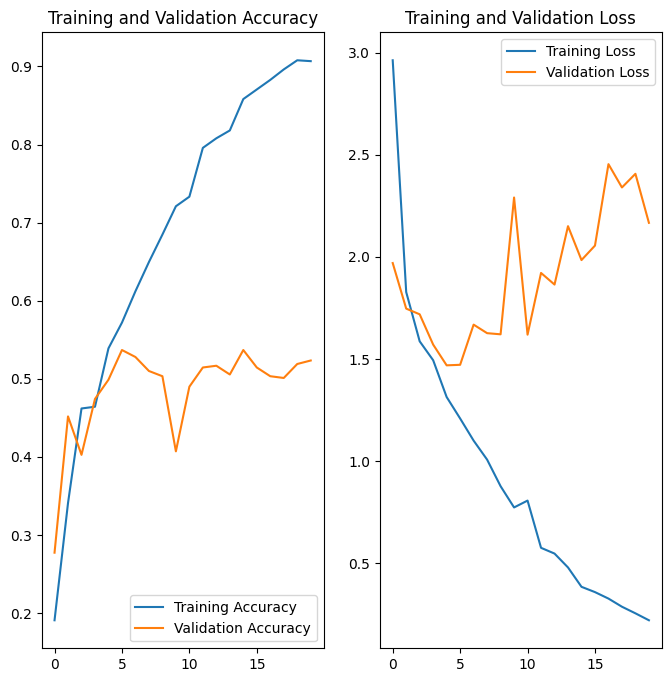

In [17]:
# Extract training and validation accuracy history from the 'history' object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract training and validation loss history from the 'history' object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis of the plot
epochs_range = range(epochs)

# Create a figure with two subplots for accuracy and loss visualization
plt.figure(figsize=(8, 8))

# Subplot 1: Plot training and validation accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')  # Add a legend indicating which line corresponds to what
plt.title('Training and Validation Accuracy')  # Set the title for this subplot

# Subplot 2: Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')  # Add a legend indicating which line corresponds to what
plt.title('Training and Validation Loss')  # Set the title for this subplot

# Display the entire figure with both subplots
plt.show()



### Findings:
- Ideally, the training accuracy and validation accuracy should be close to each other. This means that the model is able to generalize well to unseen data. However, in this case, the validation accuracy is significantly lower than the training accuracy. This suggests that the CNN is overfitting to the training data.
- As the training accuracy increases linearly over time, where as the validation accuracy stall at 50% accuracy in training process.
- As the training loss dereases with epochs the validation loss increases
- The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around <b>50%</b> accuracy on the validation set.
- The difference in accuracy between training and validation accuracy is <b>noticeable</b> which is a sign of overfitting.

# Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

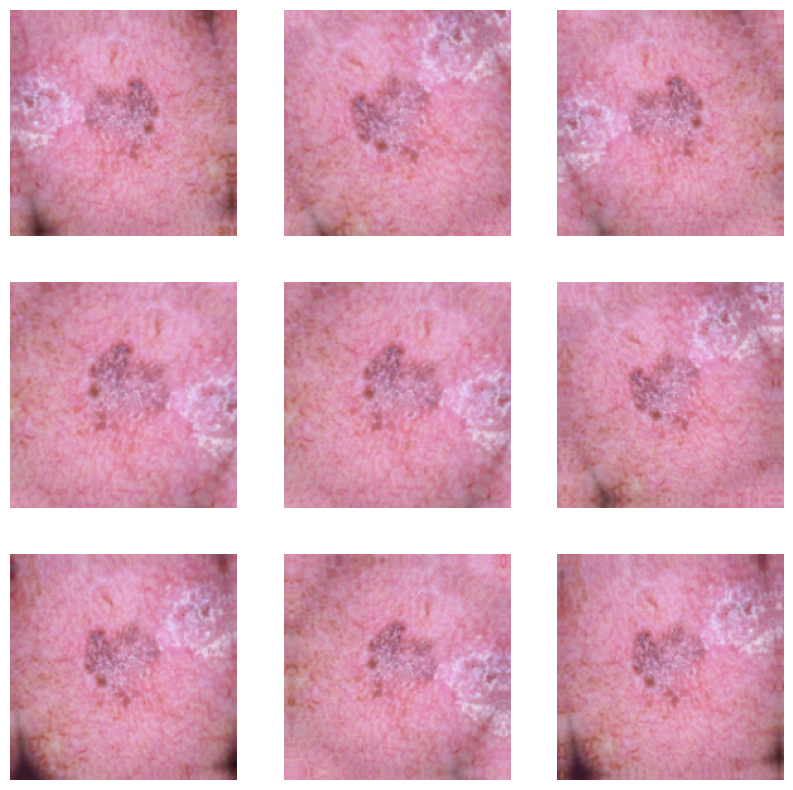

In [19]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building & training on the augmented data :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

## Model Architecture
#### This Convolutional Neural Network (CNN) is designed for image classification tasks.
#### It starts with input preprocessing and possibly data augmentation (not shown).
#### The architecture consists of convolutional layers for feature extraction, max-pooling for downsampling, and dense layers for classification.

In [20]:
# Create a Sequential model
model = models.Sequential()

# Add a Rescaling layer to scale input pixel values to the range [0, 1]
# and specify the input shape as (180, 180, 3) for images
model.add(layers.Rescaling(scale=1./255, input_shape=(180, 180, 3)))

# Add a data augmentation layer (not shown) for improving model generalization by applying random transformations to training data.
model.add(data_augmentation)

# Add a convolutional layer with 64 filters, each of size (3, 3),
# using 'same' padding, and ReLU activation function
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

# Add a max-pooling layer to downsample the feature maps
model.add(layers.MaxPooling2D())

# Add another convolutional layer with 128 filters, each of size (3, 3),
# using 'same' padding, and ReLU activation function
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))

# Add another max-pooling layer to downsample the feature maps
model.add(layers.MaxPooling2D())

# Flatten the 2D feature maps into a 1D vector
model.add(layers.Flatten())

# Add a fully connected (dense) layer with 256 units and ReLU activation
model.add(layers.Dense(256, activation='relu'))

# Add the output layer with 9 units and softmax activation for classification
model.add(layers.Dense(9, activation='softmax'))

In [21]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [22]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 75ms/step - loss: 2.8641 - accuracy: 0.2768 - val_loss: 1.7274 - val_accuracy: 0.3848
Epoch 2/20
56/56 [==============================] - 4s 68ms/step - loss: 1.6587 - accuracy: 0.4046 - val_loss: 1.5293 - val_accuracy: 0.5034
Epoch 3/20
56/56 [==============================] - 4s 70ms/step - loss: 1.4967 - accuracy: 0.4849 - val_loss: 1.4477 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 4s 68ms/step - loss: 1.4220 - accuracy: 0.4967 - val_loss: 1.4542 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3922 - accuracy: 0.4994 - val_loss: 1.5516 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 4s 78ms/step - loss: 1.3232 - accuracy: 0.5296 - val_loss: 1.4238 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 4s 68ms/step - loss: 1.3008 - accuracy: 0.5419 - val_loss: 1.3810 - val_accuracy: 0.5391
Epoch 8/20
56

#Visualizing the Accuracy and Loss
- visualizing the training and validation accuracy as well as training and validation loss over a range of epochs.

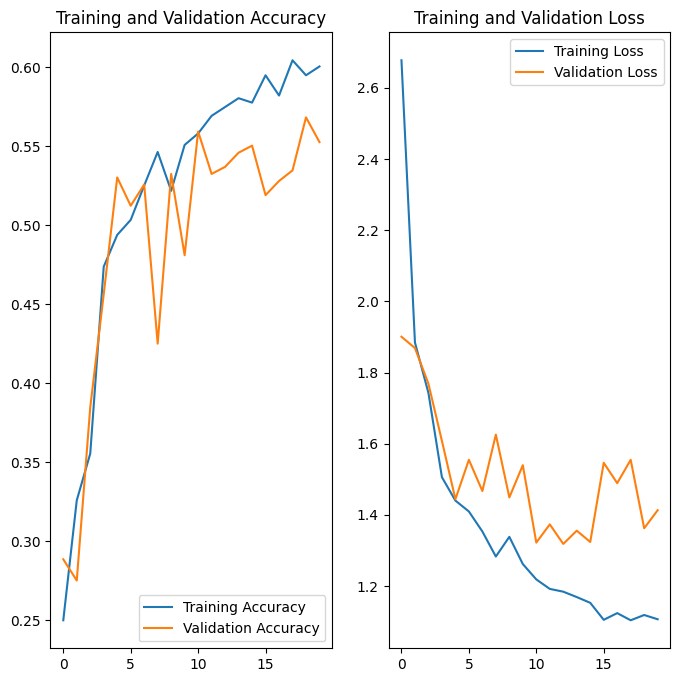

In [ ]:
# Extract training and validation accuracy history from the 'history' object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract training and validation loss history from the 'history' object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis of the plot
epochs_range = range(epochs)

# Create a figure with two subplots for accuracy and loss visualization
plt.figure(figsize=(8, 8))

# Subplot 1: Plot training and validation accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')  # Add a legend indicating which line corresponds to what
plt.title('Training and Validation Accuracy')  # Set the title for this subplot

# Subplot 2: Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')  # Add a legend indicating which line corresponds to what
plt.title('Training and Validation Loss')  # Set the title for this subplot

# Display the entire figure with both subplots
plt.show()


### Findings:
- The training accuracy consistently improves over time, while the validation accuracy plateaus at approximately 55% during the training process.
- Similarly, the training loss decreases with each epoch, but the validation loss exhibits a similar behavior, stabilizing.
- Comparing to the previous model, there is a reduced gap between training and validation accuracy, with the model achieving roughly 55% accuracy on the validation set.
- Although the gap has narrowed, a slight discrepancy between training and validation accuracy remains, indicating a mild presence of <b>overfitting</b>.

# Model Building & training on the augmented data with dropout :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [25]:
# Create a Sequential model for a Convolutional Neural Network (CNN).
model=models.Sequential()
# Add a Rescaling layer to scale input pixel values to the range [0, 1]
# and specify the input shape as (180, 180, 3) for images.
model.add(layers.Rescaling(scale=1./255, input_shape=(180, 180, 3)))

# Add a data augmentation layer (not shown) to enhance model generalization
# by applying random transformations to training data.
model.add(data_augmentation)

# Add a convolutional layer with 64 filters, each of size (3, 3),
# using 'same' padding, and ReLU activation function.
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

# Add a max-pooling layer to downsample the feature maps.
model.add(layers.MaxPooling2D())

# Add another convolutional layer with 128 filters, each of size (3, 3),
# using 'same' padding, and ReLU activation function.
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))

# Add another max-pooling layer to downsample the feature maps.
model.add(layers.MaxPooling2D())

# Add a dropout layer with a 20% dropout rate to prevent overfitting.
model.add(layers.Dropout(0.2))

# Flatten the 2D feature maps into a 1D vector.
model.add(layers.Flatten())

# Add a fully connected (dense) layer with 256 units and ReLU activation.
model.add(layers.Dense(256, activation='relu'))

# Add the output layer with 9 units and softmax activation for classification.
model.add(layers.Dense(9, activation='softmax'))

In [26]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [27]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 109ms/step - loss: 2.5691 - accuracy: 0.2461 - val_loss: 1.8528 - val_accuracy: 0.3647
Epoch 2/20
56/56 [==============================] - 6s 109ms/step - loss: 1.6815 - accuracy: 0.3945 - val_loss: 1.5005 - val_accuracy: 0.4966
Epoch 3/20
56/56 [==============================] - 6s 110ms/step - loss: 1.5359 - accuracy: 0.4632 - val_loss: 1.5960 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 6s 108ms/step - loss: 1.5151 - accuracy: 0.4581 - val_loss: 1.5422 - val_accuracy: 0.4676
Epoch 5/20
56/56 [==============================] - 6s 110ms/step - loss: 1.4646 - accuracy: 0.4939 - val_loss: 1.5179 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 6s 105ms/step - loss: 1.4381 - accuracy: 0.4888 - val_loss: 1.4009 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 6s 105ms/step - loss: 1.3244 - accuracy: 0.5407 - val_loss: 1.4886 - val_accuracy: 0.5101
Epoch 

#Visualizing the Accuracy and Loss
- visualizing the training and validation accuracy as well as training and validation loss over a range of epochs.

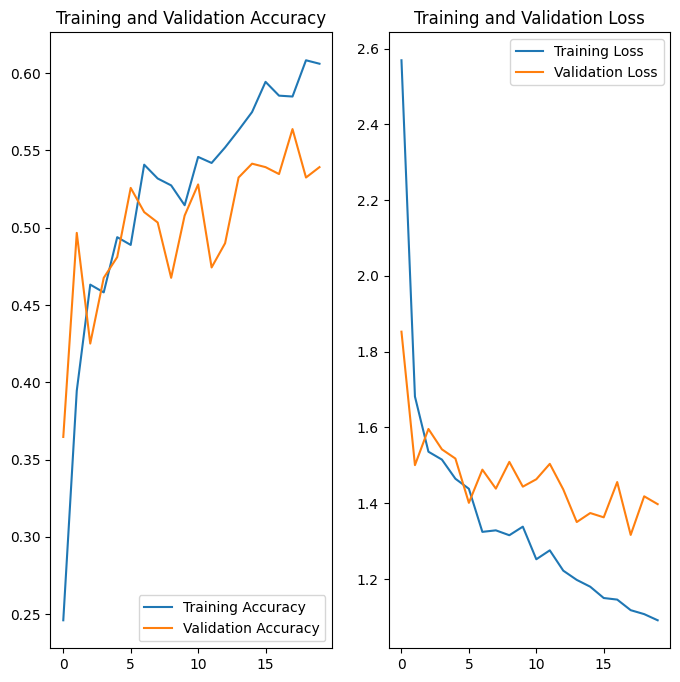

In [28]:
# Extract training and validation accuracy history from the 'history' object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract training and validation loss history from the 'history' object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis of the plot
epochs_range = range(epochs)

# Create a figure with two subplots for accuracy and loss visualization
plt.figure(figsize=(8, 8))

# Subplot 1: Plot training and validation accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')  # Add a legend indicating which line corresponds to what
plt.title('Training and Validation Accuracy')  # Set the title for this subplot

# Subplot 2: Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')  # Add a legend indicating which line corresponds to what
plt.title('Training and Validation Loss')  # Set the title for this subplot

# Display the entire figure with both subplots
plt.show()


### Findings:
- <b>As the training loss decreases with epochs the validation loss decreases</b> but a plateau after a certain point.
- The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>55%</b> accuracy on the validation set.
- The difference in accuracy between training and validation accuracy is <b>very less</b>

### **We are at a controlled overfitting environment but much more could be done**

#### **Context:**
- Real-life datasets often exhibit class imbalance, where certain classes have a significantly higher number of samples than others.
- Class imbalance can adversely affect the quality of machine learning models, leading to biased predictions and reduced performance on minority classes.
- To ensure model fairness and effectiveness, it is crucial to assess and address class distribution imbalances in the dataset.

# Class distribution:

- Evaluating the existing class distribution within the training dataset.
- Class imbalances, where one class may have a significantly larger number of samples than others, can negatively impact model quality. Therefore, it is crucial to assess and address these imbalances to ensure the model's effectiveness.

In [29]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


In [42]:
# Initialize empty lists to store class names and corresponding sample counts
class_cat = []
samples = []

# Define a function to calculate and return the class distribution in an image directory
def class_distribution_img(directory):
  # Iterate through the class names
  for i in range(len(class_names)):
    # Append the class name to the 'class_cat' list
    class_cat.append(class_names[i])
    # Count the number of image files in the directory for each class and append to 'samples' list
    samples.append(len(list(directory.glob(class_names[i]+'/*.jpg'))))

  # Create a Pandas DataFrame to store the class distribution information
  return pd.DataFrame(list(zip(class_cat, samples)), columns=['Class', 'No. of Samples'])

# Call the 'class_distribution_img' function with the training data directory and store the result in 'df'
df = class_distribution_img(data_dir_train)

[Text(0, 0, '462'),
 Text(0, 0, '438'),
 Text(0, 0, '376'),
 Text(0, 0, '357'),
 Text(0, 0, '181'),
 Text(0, 0, '139'),
 Text(0, 0, '114'),
 Text(0, 0, '95'),
 Text(0, 0, '77')]

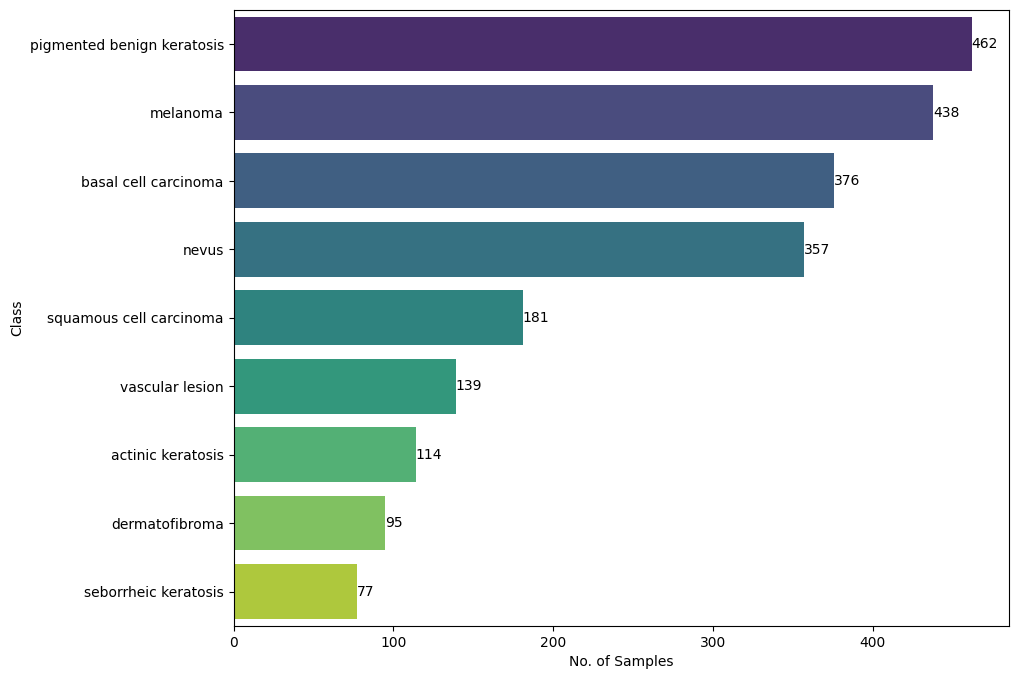

In [47]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="No. of Samples", y="Class", data=df,
            label="Class", order=df.sort_values('No. of Samples', ascending=False).Class, palette='viridis')

# now simply assign the bar values to each bar by passing containers method to bar_label function
ax.bar_label(ax.containers[0])


#### Findings
#### - Which class has the least number of samples?
       seborrheic keratosis has the least number with 77 samples

#### - Which classes dominate the data in terms proportionate number of samples?
      pigmented benign keratosis with 462 samples


# Rebalancing Classes:

Addressing class imbalances within the training dataset through the utilization of the Augmentor library for data augmentation and rebalancing.

In [48]:
!pip install Augmentor

In [49]:
path_to_training_dataset="gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
   p = Augmentor.Pipeline(path_to_training_dataset + i)
   p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
   p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EF550FF1C90>: 100%|██████████| 500/500 [00:22<00:00, 22.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EF550E7CFA0>: 100%|██████████| 500/500 [00:25<00:00, 19.71 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EF550E53D90>: 100%|██████████| 500/500 [00:25<00:00, 19.79 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EF46C633FA0>: 100%|██████████| 500/500 [01:37<00:00,  5.13 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7EF56ED30F10>: 100%|██████████| 500/500 [01:12<00:00,  6.91 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EF5517F6C20>: 100%|██████████| 500/500 [00:16<00:00, 29.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EF551B7E620>: 100%|██████████| 500/500 [00:41<00:00, 12.18 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EF5518BC1F0>: 100%|██████████| 500/500 [00:16<00:00, 30.26 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EF550DBC1F0>: 100%|██████████| 500/500 [00:16<00:00, 29.94 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [50]:
data_dir_train =("gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")

### Lets see the distribution of augmented data after adding new images to the original training data.

In [51]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [52]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [54]:
# initializing the parameter to load the images
batch_size = 32
img_height, img_width = 180, 180

In [55]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


##### So here we can see we have added around 4500 new images using augmentor. So now the total no of images are 4500 + 2239 = 6739 images

In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# Model Building & training on the rectified class imbalance data :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~30 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [57]:
# CNN Model
# Create a Sequential model for a neural network.
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [58]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [59]:
# Training the model with 30 epochs now
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 45s 241ms/step - loss: 2.7824 - accuracy: 0.2621 - val_loss: 1.6669 - val_accuracy: 0.3816
Epoch 2/30
169/169 [==============================] - 48s 277ms/step - loss: 1.6016 - accuracy: 0.3956 - val_loss: 1.6121 - val_accuracy: 0.3920
Epoch 3/30
169/169 [==============================] - 42s 240ms/step - loss: 1.5050 - accuracy: 0.4227 - val_loss: 1.4939 - val_accuracy: 0.4425
Epoch 4/30
169/169 [==============================] - 42s 240ms/step - loss: 1.4339 - accuracy: 0.4514 - val_loss: 1.3545 - val_accuracy: 0.4885
Epoch 5/30
169/169 [==============================] - 41s 238ms/step - loss: 1.3481 - accuracy: 0.4881 - val_loss: 1.3492 - val_accuracy: 0.4863
Epoch 6/30
169/169 [==============================] - 41s 239ms/step - loss: 1.3173 - accuracy: 0.5054 - val_loss: 1.3182 - val_accuracy: 0.5033
Epoch 7/30
169/169 [==============================] - 41s 239ms/step - loss: 1.2600 - accuracy: 0.5156 - val_loss: 1.2138 - val_ac

#Visualizing the Accuracy and Loss
- visualizing the training and validation accuracy as well as training and validation loss over a range of epochs.

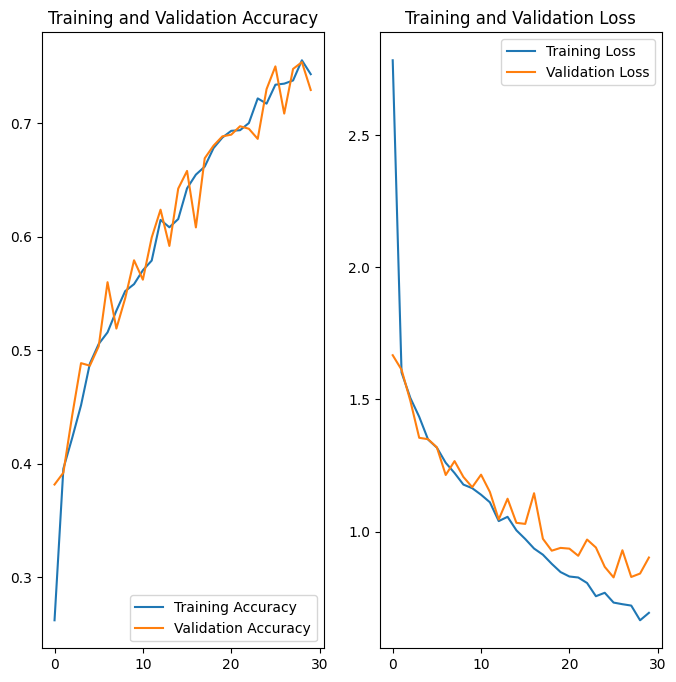

In [60]:
# Extract training and validation accuracy history from the 'history' object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract training and validation loss history from the 'history' object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis of the plot
epochs_range = range(epochs)

# Create a figure with two subplots for accuracy and loss visualization
plt.figure(figsize=(8, 8))

# Subplot 1: Plot training and validation accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')  # Add a legend indicating which line corresponds to what
plt.title('Training and Validation Accuracy')  # Set the title for this subplot

# Subplot 2: Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')  # Add a legend indicating which line corresponds to what
plt.title('Training and Validation Loss')  # Set the title for this subplot

# Display the entire figure with both subplots
plt.show()

## Conclusion

- As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.
- As the training loss decreases with epochs the validation loss also decreases.
- The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around <b>74%</b> accuracy on the validation set.
- The difference in accuracy between training and validation accuracy is very less

### Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 74%.